In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from munch import Munch

## load throughput csv data and filter for vocab size 16384

In [2]:
df = pd.read_csv("throughput_results.csv")
df.columns

Index(['batch_size', 'vocab_size', 'config_name', 'seq_len', 'n_layers',
       'h_dim', 'mlp_dim', 'head_dim', 'n_heads', 'compile', 'class', 'config',
       'performance test', 'number of parameters',
       'number of non-embedding parameters', 'device',
       'model memory usage megabytes', 'step memory usage in megabytes',
       'tokens per batch', 'avg step duration in ms',
       'std step duration in ms', 'avg iterations per second',
       'std iterations per second', 'tokens per second', 'OOM', 'flops',
       'macs', 'params'],
      dtype='object')

In [3]:
is_quasi_lst = []
for m in df['config'].to_list():
    m = eval(m)
    if 'is_quasi' in m.keys():
        is_quasi_lst.append(m['is_quasi'])
    else:
        is_quasi_lst.append(False)
df = df.assign(is_quasi=is_quasi_lst)

In [4]:
# set of configs
vocabs = set(df['vocab_size'])
vocabs

{16384}

In [5]:
# set of configs
config_names = set(df['config_name'])
config_names

{'XL', 'large', 'medium', 'mini', 'small', 'tiny'}

In [6]:
# set of devices
devices = set(df['device'])
devices

{'NVIDIA A100-SXM4-80GB',
 'NVIDIA GeForce RTX 3090',
 'NVIDIA GeForce RTX 4090',
 'Tesla V100-SXM2-32GB-LS'}

In [7]:
vocab_size = 16_384
df = df[(df.vocab_size == vocab_size)]

## Get the number of FLOPs for every config

In [8]:
for c in config_names:
    flops = set(df[(df.config_name == c) & (df.batch_size == 1)]['flops'])
    print(f"{c}:\t{flops}")

large:	{'722.39 G', '780.37 G'}
small:	{'107.32 G', '100.07 G'}
medium:	{'352.74 G'}
tiny:	{'44.34 G', '41.92 G'}
mini:	{'19.89 G', '19.36 G'}
XL:	{'1633.63 G'}


## Get the best throughput for every config on every device

In [9]:
best_throughputs = []
for d in devices:
    for c in config_names:
        throughput_df = df[(df.config_name == c) & (df.device == d)][['tokens per second']]
        if len(throughput_df) > 0:            
            best_df = df.loc[throughput_df.idxmax()][['batch_size', 'tokens per second']]
            best_bsz = best_df['batch_size'].values[0]
            best_throughput = best_df['tokens per second'].values[0]
            #print(f"{d}\t{c}\t{best_throughput:,} ({best_bsz})")
            best_throughputs.append((d, c, best_throughput, best_bsz))
        else:
            pass
            #print(f"{d}\t{c}\tN/A")
            #best_throughputs.append((d, c, "N/A", "N/A"))
    #print("-" * 10)

In [10]:
best_df = pd.DataFrame(best_throughputs, columns=['device', 'config', 'throughput', 'batch size'])
best_df

,device,config,throughput,batch size
0,NVIDIA GeForce RTX 3090,large,1006,2
1,NVIDIA GeForce RTX 3090,small,11143,17
2,NVIDIA GeForce RTX 3090,medium,2509,5
3,NVIDIA GeForce RTX 3090,tiny,36930,60
4,NVIDIA GeForce RTX 3090,mini,94781,82
5,NVIDIA GeForce RTX 4090,large,1002,2
6,NVIDIA GeForce RTX 4090,small,16312,16
7,NVIDIA GeForce RTX 4090,medium,2601,5
8,NVIDIA GeForce RTX 4090,tiny,57454,61
9,NVIDIA GeForce RTX 4090,mini,166178,82


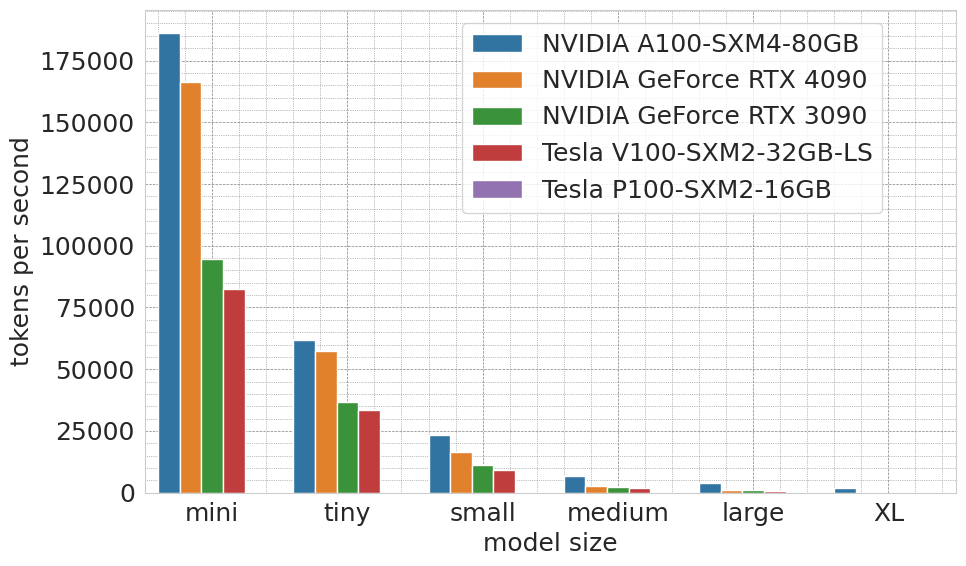

In [11]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=best_df, y='throughput', x='config', hue='device',
                order=['mini', 'tiny', 'small', 'medium', 'large', 'XL'],
                hue_order=['NVIDIA A100-SXM4-80GB',
                           'NVIDIA GeForce RTX 4090',
                           'NVIDIA GeForce RTX 3090',
                           'Tesla V100-SXM2-32GB-LS',
                           'Tesla P100-SXM2-16GB',
                          ])
ax.set_xlabel('model size')
ax.set_ylabel('tokens per second')
#ax.set_yscale('log')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
plt.legend(bbox_to_anchor=(0.65, 1.0), loc='upper center', ncol=1)

#ax.set_yscale('log')
plt.tight_layout()
plt.savefig('throughputs_per_device.pdf')

## Plot Throughput Over Batch Sizes

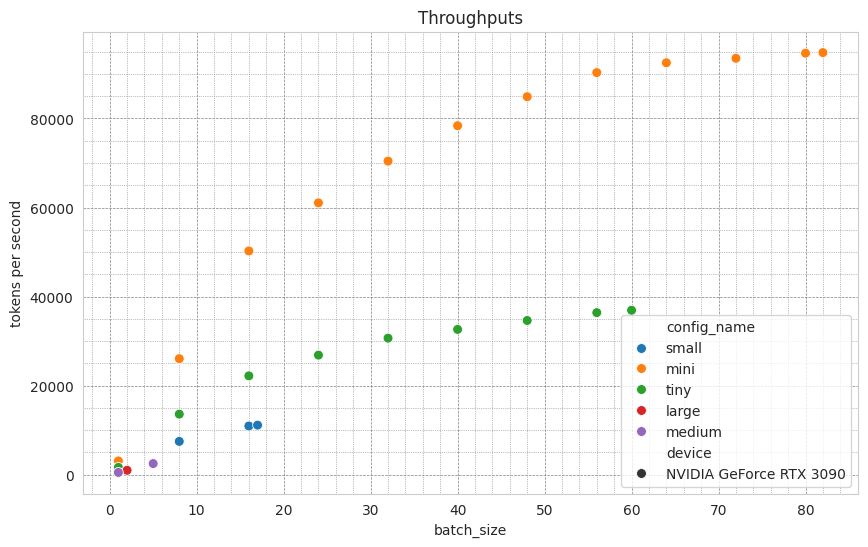

In [12]:
fdf = df[(df.vocab_size == vocab_size) & (df['tokens per second'] > 0) & (df.device.str.contains('3090'))]

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=fdf, y='tokens per second', x='batch_size', hue='config_name', style='device', s=50)
plt.title('Throughputs')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
#plt.xscale('log')

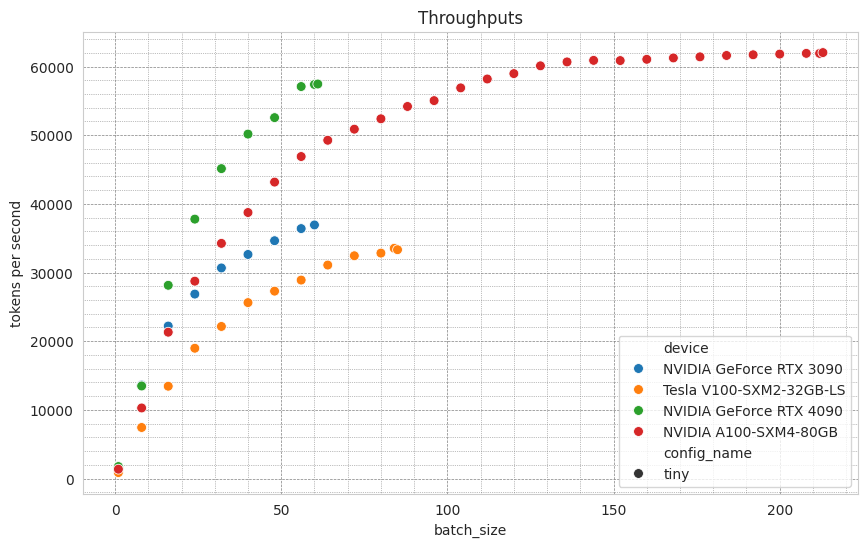

In [13]:
fdf = df[(df.vocab_size == vocab_size) & (df.config_name.str.contains('tiny')) & (df['tokens per second'] > 0)]

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=fdf, y='tokens per second', x='batch_size', hue='device', style='config_name', s=50)
plt.title('Throughputs')

# Add more gridlines
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)


## Compute training steps for a specific number of gpu hours and batch size

In [14]:
# EDIT THE NUMBER OF RTX 3090 GPU HOURS AND MODEL SIZE HERE AND RERUN ALL CELLS BELOW
gpu_hours = 6
config_name = 'mini'
device = '3090'

In [15]:
fdf = df[(df.vocab_size == vocab_size) & (df.device.str.contains(device)) & (df['tokens per second'] > 0)]
tokens_per_second = fdf[fdf['config_name']==config_name]['tokens per second'].max()

fdf[(fdf['config_name']==config_name) & (fdf['tokens per second'] == tokens_per_second)][['config_name', 'is_quasi', 'vocab_size', 'batch_size', 'tokens per second', 'device']]

,config_name,is_quasi,vocab_size,batch_size,tokens per second,device
18,mini,True,16384,82,94781,NVIDIA GeForce RTX 3090


In [16]:
print(tokens_per_second)

94781


In [17]:
tokens = gpu_hours * 60 * 60 * tokens_per_second
print(f"tokens to process: {tokens:,}")

tokens to process: 2,047,269,600


In [18]:
bsz = 80
seq_len = 512

steps = round(tokens / bsz / seq_len)
print(f"train steps: {steps:}")

train steps: 49982


In [19]:
n_workers = 1
gradient_accumulation_steps = 1
bsz / n_workers / gradient_accumulation_steps

80.0

In [20]:
print(f"{tokens / (n_workers * tokens_per_second) / 60 / 60:.2f} hours estimated running time")

6.00 hours estimated running time


In [21]:
df[
    (df.config_name == config_name) & 
    (df.vocab_size == vocab_size) &
    (df.device.str.contains('V100'))
][['config_name', 'batch_size', 'tokens per second', 'device']]

,config_name,batch_size,tokens per second,device
70,mini,1,1710,Tesla V100-SXM2-32GB-LS
71,mini,8,13118,Tesla V100-SXM2-32GB-LS
72,mini,16,26027,Tesla V100-SXM2-32GB-LS
73,mini,24,39252,Tesla V100-SXM2-32GB-LS
74,mini,32,49610,Tesla V100-SXM2-32GB-LS
75,mini,40,56757,Tesla V100-SXM2-32GB-LS
76,mini,48,61079,Tesla V100-SXM2-32GB-LS
77,mini,56,66968,Tesla V100-SXM2-32GB-LS
78,mini,64,69813,Tesla V100-SXM2-32GB-LS
79,mini,72,74563,Tesla V100-SXM2-32GB-LS
